In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/Colab Notebooks/Github/Colab_Notebook

/content/drive/MyDrive/Colab Notebooks/Github/Colab_Notebook


In [3]:
!git config --global user.email 'inseop.hwang@hotmail.com'
!git config --global user.name 'Hot-Kimchi'

In [6]:
!git add .
!git status
!git add 8_3_2_Pretrained_finetuning.ipynb

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
fatal: pathspec '8_3_2_Pretrained_finetuning.ipynb' did not match any files


In [5]:
!git commit -m 'finefuning method for CNN'
!git push -u origin main

[main e7c9ba9] finefuning method for CNN
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite 8_3_1_Pretrained_freezing.ipynb (96%)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 566 bytes | 113.00 KiB/s, done.
Total 3 (delta 1), reused 0 (delta 0)
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/Hot-KimChi/Colab_Notebook.git
   67ecfa1..e7c9ba9  main -> main
Branch 'main' set up to track remote branch 'main' from 'origin'.


>### 작은 이미지 데이터셋에 딥러닝을 적용하는 일반적이고 매우 효과적인 방법
- 사전 훈련된 모델 사용(pretrained model): ex) 1400만개의 레이블된 이미지 데이터 & 대규모 컨브넷
  - 1) 특성 추출
  - 2) 미세 조정

>#### 2) 사전 훈련된 모델 미세 조정하기
- 미세 조정
  - 특성 추출에 사용했던 동결 모델의 상위 층 몇 개를 동결에서 해제하고 모델에 새로 추가한 층과 함께 훈련하는 것
- 순서
  - a) 새로 추가한 밀집 연결분류기가 먼저 훈련
  - b) 합성곱 기반의 상위 층 미세조정
  - * 분류기가 미리 훈련되지 않으면 훈련되는 동안 너무 큰 오차 신호가 네트워크에 전파

  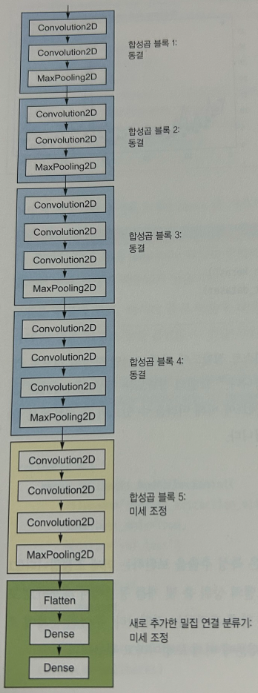


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

conv_base = keras.applications.vgg16.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(180, 180, 3)
)

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

>### Data download

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import gdown
gdown.download(id='18uC7WTuEXKJDDxbj-Jq6EjzpFrgE7IAd', output='dogs-vs-cats.zip')

Downloading...
From: https://drive.google.com/uc?id=18uC7WTuEXKJDDxbj-Jq6EjzpFrgE7IAd
To: /content/dogs-vs-cats.zip
100%|██████████| 852M/852M [00:07<00:00, 112MB/s]


'dogs-vs-cats.zip'

In [ ]:
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


>### 최종 특성 맵의 크기 (5, 5, 512)
- 이 지점에서 2가지 방식이 가능
  - 1) 새로운 데이터셋에서 합성곱 기반 층을 실행, 출력을 넘파이 배열로 디스크 저장(without 데이터증식)
    - 저장된 데이터를 독립된 밀집 연결 분류기에 입력으로 사용
    - 합성곱 연산은 전체 과정 중, 가장 비싼 부분
    - 모든 입력 이미지에 합성곱 기반 층을 한번만 실행, 비용이 적게 소요되나 데이터 증식 사용 불가능
  - 2) 준비된 모델 위에 Dense 층을 쌓아 확장(with 데이터 증식)
    - 입력 데이터에서 엔드-투-엔드로 전체 모델 실행
    - 모든 입력 이미지가 매번 합성곱 기반층을 통과되기에 데이터 증식 사용 가능
    - 이러한 방식때문에 비용이 휠씬 많이 발생.

>#### 1) 합성곱 기반 층을 실행 & 출력을 넘파이로 저장

In [ ]:
## 데이터 증식을 사용하지 않는 빠른 특성추출
import numpy as np

def get_features_and_labels(dataset):
  all_features = []
  all_labels = []

  for images, labels in dataset:
    preprocessed_images = keras.applications.vgg16.preprocess_input(images)
    features = conv_base.predict(preprocessed_images)
    all_features.append(features)
    all_labels.append(labels)
  
  return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 31ms/step


In [ ]:
train_features.shape

(2000, 5, 5, 512)

>#### 규제를 위해 드롭아웃 사용한 밀집 연결 분류기 정의 및 훈련

In [ ]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, outputs)
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint(
    filepath='feature_extraction.keras',
    save_best_only=True,
    monitor='val_loss')
]

history = model.fit(train_features, train_labels,
                    epochs=20, 
                    validation_data=(val_features, val_labels),
                    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 2s 11ms/step - loss: 23.6915 - accuracy: 0.9210 - val_loss: 3.6289 - val_accuracy: 0.9680
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 3.1429 - accuracy: 0.9695 - val_loss: 5.8127 - val_accuracy: 0.9600
Epoch 3/20
63/63 [==============================] - 0s 8ms/step - loss: 2.5493 - accuracy: 0.9850 - val_loss: 4.6127 - val_accuracy: 0.9740
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 1.2229 - accuracy: 0.9895 - val_loss: 6.1270 - val_accuracy: 0.9700
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 0.7870 - accuracy: 0.9965 - val_loss: 5.1675 - val_accuracy: 0.9760
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 0.5920 - accuracy: 0.9940 - val_loss: 3.9506 - val_accuracy: 0.9790
Epoch 7/20
63/63 [==============================] - 0s 8ms/step - loss: 0.6141 - accuracy: 0.9945 - val_loss: 7.6691 - val_accuracy: 0.9690
Epoch 8/20
63/63 [

>#### 결과를 그래프로 확인

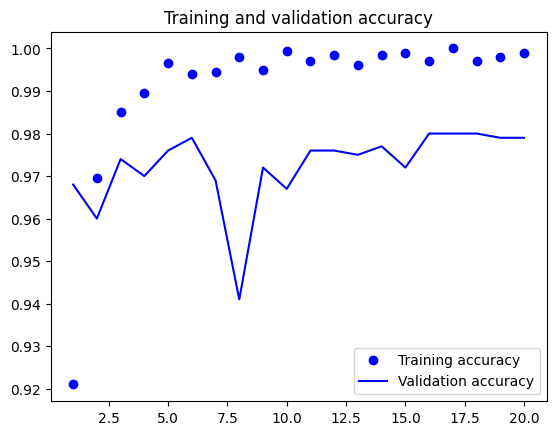

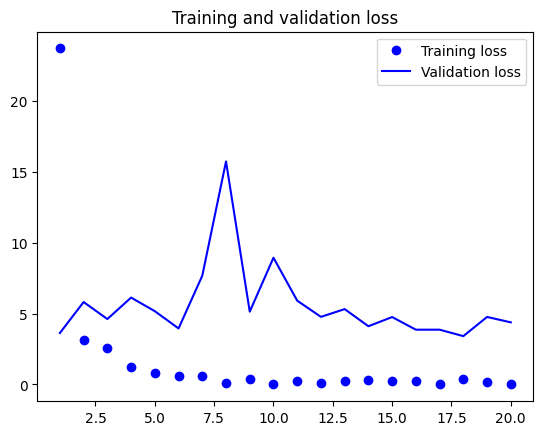

In [ ]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

>### 약 97.4%의 검증 정확도
- 많은 비율로 Dropout을 사용하였지만, 훈련 시작 시 바로 과대적합 발생
- 이를 위해 데이터 증식 기법이 필요

In [ ]:
test_model = keras.models.load_model(
    'feature_extraction.keras')

test_loss, test_acc = test_model.evaluate(test_features, test_labels)
print(f'테스트 정확도:{test_acc:.3f}')

63/63 [==============================] - 0s 3ms/step - loss: 5.5884 - accuracy: 0.9740
테스트 정확도:0.974


>#### 2) 데이터 증식을 사용한 특성 추출
  - 휠씬 느리고 비용이 많이 들지만 훈련하는 동안 데이터 증식 기법 사용 가능
  - 방법: conv_base + 새로운 밀집 분류기 연결 모델 생성 --> 입력 데이터 사용하여 엔드-투-엔드 실행
    - 합성곱 기반 층 동결(freezing): 훈련하는 동안 가중치가 업데이트되지 않도록 막는다 --> 합성곱 기반 층에 의해 사전에 학습된 표현이 훈련하는 동안 수정 혹은 훼손 발생

In [ ]:
conv_base_frz = keras.applications.vgg16.VGG16(
    weights='imagenet',
    include_top=False)

## False으로 인해 층이나 모델을 동결 / 즉, 훈련 가능한 가중치 리스트가 텅 비게된다.
conv_base_frz.trainable = False

In [ ]:
## Freezing 전후 비교
conv_base_frz.trainable = True
print('합성곱 기반 층 동결 전의 훈련 가능한 가중치 개수:', 
      len(conv_base_frz.trainable_weights))

합성곱 기반 층 동결 전의 훈련 가능한 가중치 개수: 26


In [ ]:
## Freezing 전후 비교
conv_base_frz.trainable = False
print('합성곱 기반 층 동결 전의 훈련 가능한 가중치 개수:', 
      len(conv_base_frz.trainable_weights))

합성곱 기반 층 동결 전의 훈련 가능한 가중치 개수: 0


>#### 아래 3단계를 연결하여, 새로운 모델 구성 가능
- 1) 데이터 증식 단계
- 2) 동결된 합성곱 기반 층
- 3) 밀집 분류기

In [ ]:
## 데이터 증식단계 추가하기
data_augmentation = keras.Sequential(
    [        
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [ ]:
##밀집 분류기를 합성곱 기반 층에 추가하기
inputs = keras.Input(shape=(180, 180, 3))

x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)    ## 입력값의 스케일 조정
x = conv_base_frz(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation='sigmoid')(x)

model_aug = keras.Model(inputs, outputs)
model_aug.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath='feature_extraction_with_data_augmentation.keras',
    save_best_only=True,
    monitor='val_loss')
]

history = model_aug.fit(
    train_dataset,
    epochs=50, 
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 12s 158ms/step - loss: 20.6510 - accuracy: 0.8935 - val_loss: 3.0745 - val_accuracy: 0.9750
Epoch 2/50
63/63 [==============================] - 10s 161ms/step - loss: 6.5305 - accuracy: 0.9410 - val_loss: 2.7981 - val_accuracy: 0.9720
Epoch 3/50
63/63 [==============================] - 11s 166ms/step - loss: 5.9348 - accuracy: 0.9555 - val_loss: 3.2602 - val_accuracy: 0.9750
Epoch 4/50
63/63 [==============================] - 12s 184ms/step - loss: 4.5577 - accuracy: 0.9615 - val_loss: 3.7984 - val_accuracy: 0.9740
Epoch 5/50
63/63 [==============================] - 10s 159ms/step - loss: 4.0683 - accuracy: 0.9680 - val_loss: 5.2018 - val_accuracy: 0.9700
Epoch 6/50
63/63 [==============================] - 11s 164ms/step - loss: 4.7276 - accuracy: 0.9645 - val_loss: 3.1903 - val_accuracy: 0.9770
Epoch 7/50
63/63 [==============================] - 12s 186ms/step - loss: 2.0312 - accuracy: 0.9775 - val_loss: 3.4987 - val_accuracy: 0.977

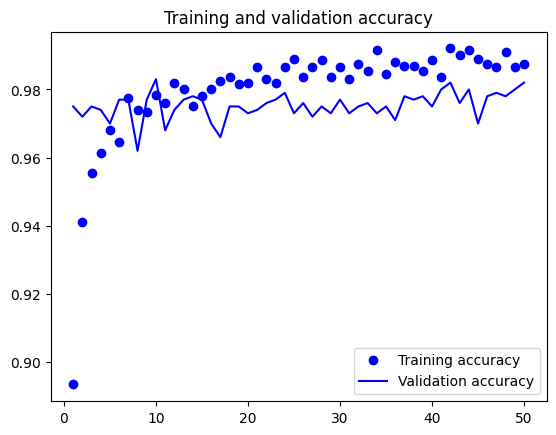

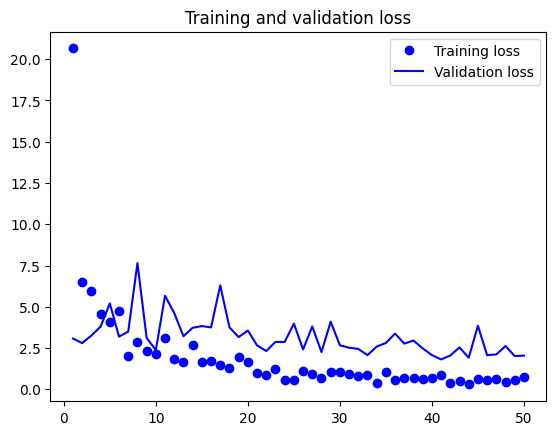

In [ ]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

>### 약 97.5%의 검증 정확도

In [ ]:
test_model = keras.models.load_model(
    'feature_extraction_with_data_augmentation.keras')

test_loss, test_acc = test_model.evaluate(test_dataset)
print(f'테스트 정확도:{test_acc:.3f}')

63/63 [==============================] - 7s 95ms/step - loss: 2.0280 - accuracy: 0.9765
테스트 정확도:0.976
